<!--
 * @Author: TMJ
 * @Date: 2024-03-08 21:11:46
 * @LastEditors: TMJ
 * @LastEditTime: 2024-03-08 21:19:40
 * @Description: 请填写简介
-->
# Structure recovery benchmark

Recovering molecular topology from coordinate files is a very practical need. Many cheminformaticians use desktop software such as Gaussian View to visually recover molecular topologies and adjust suspicious bonding relationships in them in real time. Such an approach can make the molecular structure exactly as the chemist knows it, but unfortunately it requires a lot of human involvement! There is a rising demand for automated tools when trying to construct molecular datasets from existing quantum chemistry calculations or coordinate files.

The popular open-source cheminformatics tools OpenBabel and RDKit both offer the ability to recover molecular topology from coordinate files, but unfortunately, they both suffer from some fatal problems. These problems made it impossible for me to continue my chemistry database building project, so I decided to create a new project to learn from their strengths and overcome their problems - MolOP was born for this purpose!

|     functions     | OpenBabel | RDKit | MolOP |
| :---------------: | :-------: | :---: | :---: |
| Neutral Molecule  |     😏     |   😏   |   😏   |
| Charge processing |     😰     |   😏   |   😏   |
| Metel processing  |     😏     |   😰   |   😏   |


In more detail, both OpenBabel and RDKit have some types of molecules that cannot be handled. Unfortunately these molecules are very common in my dataset, so MolOP has targeted optimisations for them.


|              target molecule              |               example                | OpenBabel | RDKit | MolOP |
| :---------------------------------------: | :----------------------------------: | :-------: | :---: | :---: |
|          simple organic molecule          |              `c1ccccc1`              |     😏     |   😏   |   😏   |
|       under-bonded organic molecule       |               `[CH3]`                |     😏     |   😰   |   😏   |
| under-bonded organic molecule with charge |               `[CH3-]`               |     😰     |   😏   |   😏   |
| under-bonded organic molecule with charge |            `c1cccc[c+]1`             |     😰     |   😰   |   😏   |
| under-bonded organic molecule with charge |            `c1cccc[c-]1`             |     😰     |   😏   |   😏   |
|       over-bonded organic molecule        |               `[NH4+]`               |     😰     |   😏   |   😏   |
|                  Dipole                   |           `C[N+](-[O-])=O`           |     😏     |   😏   |   😏   |
|                  Dipole                   |             `C[N+]#[C-]`             |     😰     |   😏   |   😏   |
|                  Dipole                   |            `C=[N+]=[N-]`             |     😰     |   😏   |   😏   |
|                   Ylide                   | `c1ccccc1-P(-c1ccccc1)(-c1ccccc1)=C` |     😰     |   😏   |   😏   |
|                Inner salt                 |        `[O-]C(=O)CCCC[NH3+]`         |     😰     |   😏   |   😏   |
|               Metal complex               |                 ...                  |     😰     |   😰   |   😏   |

In [1]:
from openbabel import pybel
from rdkit import Chem
from rdkit.Chem import AllChem, rdDetermineBonds

from molop import AutoParser
from molop.structure.structure_recovery import *


def smi2xyz(smi: str):
    mol = Chem.MolFromSmiles(smi)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    return Chem.MolToXYZBlock(mol)

## simple organic molecule

In [2]:
xyz_block = smi2xyz("c1ccccc1")
print(xyz_block)

12

C      0.794262   -1.148974    0.015000
C      1.360699    0.129837   -0.002163
C      0.589827    1.268073   -0.017027
C     -0.786625    1.145009   -0.014949
C     -1.341315   -0.112392    0.001925
C     -0.580623   -1.265551    0.016991
H      1.402552   -2.042792    0.026673
H      2.418314    0.211316   -0.003586
H      1.007452    2.268593   -0.030447
H     -1.418248    2.029280   -0.026492
H     -2.422241   -0.217238    0.003669
H     -1.024054   -2.265159    0.030406



### OpenBabel 😏

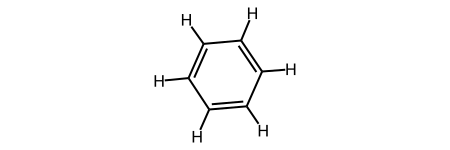

In [3]:
# SUCCESS
try:
    mol = Chem.MolFromMolBlock(
        pybel.readstring("xyz", xyz_block).write("sdf"), removeHs=False
    )
except Exception as e:
    print(e)
mol

### RDKit 😏

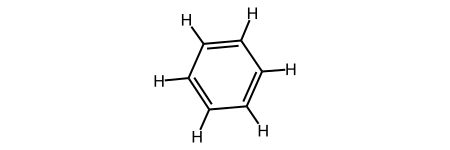

In [4]:
# SUCCESS
mol = Chem.MolFromXYZBlock(xyz_block)
try:
    rdDetermineBonds.DetermineBonds(mol, charge=0)
except Exception as e:
    print(e)
mol

### MolOP 😏

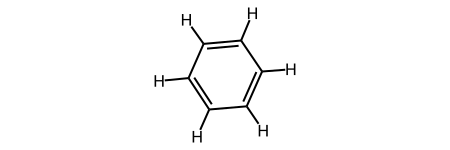

In [5]:
# SUCCESS
try:
    mol = xyz_block_to_rdmol(xyz_block, total_charge=0, total_radical=0)
except Exception as e:
    print(e)
mol

## under-bonded organic molecule (e.g. `[CH3]`)

In [6]:
xyz_block = smi2xyz("[CH3]")
print(xyz_block)

4

C     -0.009007   -0.007740    0.278249
H      0.982326   -0.321871   -0.091289
H     -0.787636   -0.694888   -0.095573
H     -0.185683    1.024499   -0.091387



### OpenBabel 😏

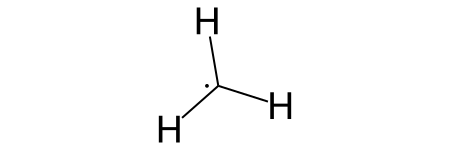

In [7]:
# SUCCESS
try:
    mol = Chem.MolFromMolBlock(
        pybel.readstring("xyz", xyz_block).write("sdf"), removeHs=False
    )
except Exception as e:
    print(e)
mol

### RDKit 😰

Final molecular charge does not match input; could not find valid bond ordering


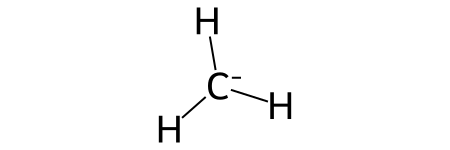

In [8]:
# FAILED
mol = Chem.MolFromXYZBlock(xyz_block)
try:
    rdDetermineBonds.DetermineBonds(mol, charge=0)
except Exception as e:
    print(e)
mol

### MolOP 😏

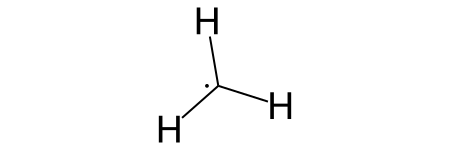

In [9]:
# SUCCESS
try:
    mol = xyz_block_to_rdmol(xyz_block, total_charge=0, total_radical=1)
except Exception as e:
    print(e)
mol

## under-bonded organic molecule with charge (e.g. `[CH3-]`)

In [10]:
xyz_block = smi2xyz("[CH3-]")
print(xyz_block)

4

C      0.015558   -0.006106    0.248600
H      1.058492   -0.164051   -0.086216
H     -0.674002   -0.805284   -0.081864
H     -0.400049    0.975441   -0.080520



### OpenBabel 😰

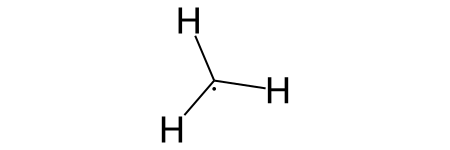

In [11]:
# FAILED
try:
    mol = Chem.MolFromMolBlock(
        pybel.readstring("xyz", xyz_block).write("sdf"), removeHs=False
    )
except Exception as e:
    print(e)
mol

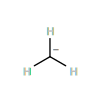

In [12]:
omol = pybel.readstring("xyz", xyz_block)
omol.OBMol.AssignTotalChargeToAtoms(-1)
omol

### RDKit 😏

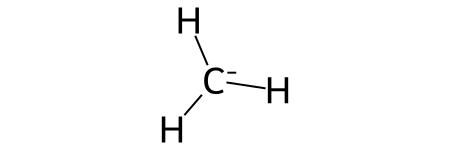

In [13]:
# SUCCESS
mol = Chem.MolFromXYZBlock(xyz_block)
try:
    rdDetermineBonds.DetermineBonds(mol, charge=-1)
except Exception as e:
    print(e)
mol

### MolOP 😏

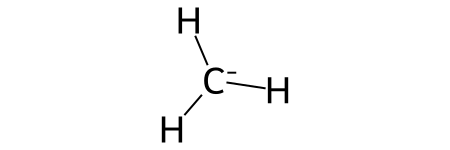

In [14]:
# SUCCESS
try:
    mol = xyz_block_to_rdmol(xyz_block, total_charge=-1, total_radical=0)
except Exception as e:
    print(e)
mol

## under-bonded organic molecule with charge (e.g. `c1cccc[c+]1`)

In [15]:
xyz_block = smi2xyz("c1cccc[c+]1")
print(xyz_block)

11

C     -1.257319   -0.734611    0.365230
C     -1.077749    0.576186    0.333634
C      0.193172    1.174867   -0.037994
C      1.177864    0.344796   -0.347997
C      0.973299   -1.091761   -0.311040
C     -0.168177   -1.600708    0.023229
H     -2.233640   -1.146734    0.651540
H     -1.903566    1.258738    0.593355
H      0.366472    2.249705   -0.071715
H      2.162936    0.747226   -0.637128
H      1.766708   -1.777703   -0.561112



### OpenBabel 😰

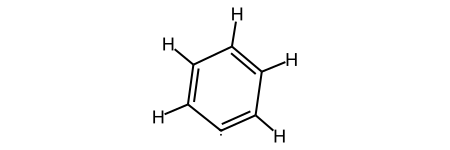

In [16]:
# FAILED
try:
    mol = Chem.MolFromMolBlock(
        pybel.readstring("xyz", xyz_block).write("sdf"), removeHs=False
    )
except Exception as e:
    print(e)
mol

### RDKit 😰

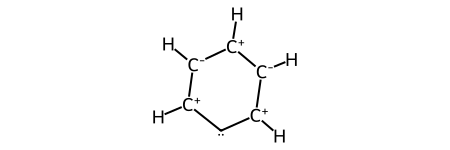

In [17]:
# FAILED
mol = Chem.MolFromXYZBlock(xyz_block)
try:
    rdDetermineBonds.DetermineBonds(mol, charge=1)
except Exception as e:
    print(e)
mol

### MolOP 😏

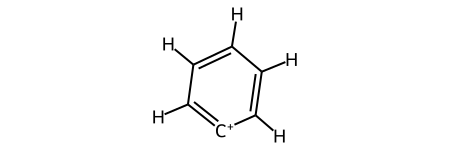

In [18]:
# SUCCESS
try:
    mol = xyz_block_to_rdmol(xyz_block, total_charge=1, total_radical=0)
except Exception as e:
    print(e)
mol

## under-bonded organic molecule with charge (e.g. `c1cccc[c-]1`)

In [19]:
xyz_block = smi2xyz("c1cccc[c-]1")
print(xyz_block)

11

C      1.369202   -0.553682   -0.002753
C      1.047180    0.786115   -0.007534
C     -0.290439    1.118685   -0.003908
C     -1.255666    0.115232    0.004298
C     -0.920652   -1.220888    0.009022
C      0.414642   -1.558754    0.005423
H      2.415039   -0.850668   -0.005506
H      1.840902    1.545172   -0.013960
H     -0.599040    2.155231   -0.007392
H     -2.292618    0.403411    0.006967
H     -1.728551   -1.939853    0.015343



### OpenBabel 😰

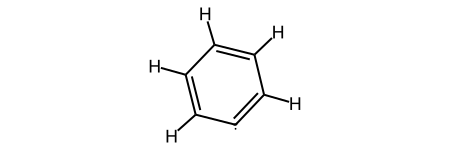

In [20]:
# FAILED
try:
    mol = Chem.MolFromMolBlock(
        pybel.readstring("xyz", xyz_block).write("sdf"), removeHs=False
    )
except Exception as e:
    print(e)
mol

### RDKit 😏

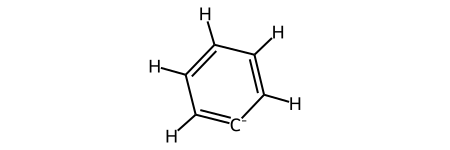

In [21]:
# SUCCESS
mol = Chem.MolFromXYZBlock(xyz_block)
try:
    rdDetermineBonds.DetermineBonds(mol, charge=-1)
except Exception as e:
    print(e)
mol

### MolOP 😏

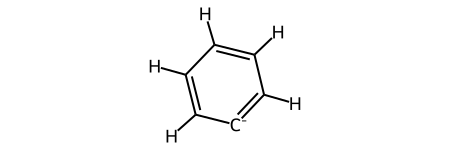

In [22]:
# SUCCESS
try:
    mol = xyz_block_to_rdmol(xyz_block, total_charge=-1, total_radical=0)
except Exception as e:
    print(e)
mol

## over-bonded organic molecule (e.g. `[NH4+]`)

In [23]:
xyz_block = smi2xyz("[NH4+]")
print(xyz_block)

5

N      0.005694   -0.008689   -0.011089
H     -0.712822   -0.155362   -0.755970
H      0.432924    0.947575   -0.069672
H     -0.497243   -0.075688    0.909461
H      0.771447   -0.707837   -0.072729



### OpenBabel 😰

In [24]:
# FAILED
try:
    mol = Chem.MolFromMolBlock(
        pybel.readstring("xyz", xyz_block).write("sdf"), removeHs=False
    )
except Exception as e:
    print(e)
mol

### RDKit 😏

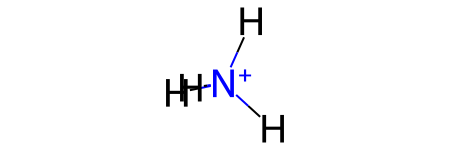

In [25]:
# SUCCESS
mol = Chem.MolFromXYZBlock(xyz_block)
try:
    rdDetermineBonds.DetermineBonds(mol, charge=1)
except Exception as e:
    print(e)
mol

### MolOP 😏

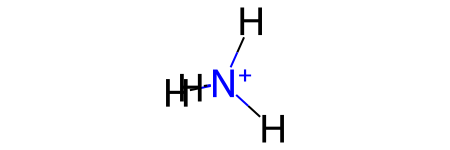

In [26]:
# SUCCESS
try:
    mol = xyz_block_to_rdmol(xyz_block, total_charge=1, total_radical=0)
except Exception as e:
    print(e)
mol

## Dipole (e.g. `C[N+](-[O-])=O`)

In [27]:
xyz_block = smi2xyz("C[N+](-[O-])=O")
print(xyz_block)

7

C     -0.640897   -0.059355    0.039171
N      0.801835   -0.012953   -0.043274
O      1.436242    1.194652   -0.214508
O      1.532890   -1.017939    0.031884
H     -0.989593   -0.051821    1.106636
H     -1.055013    0.859306   -0.422752
H     -1.085463   -0.911890   -0.497157



### OpenBabel 😏

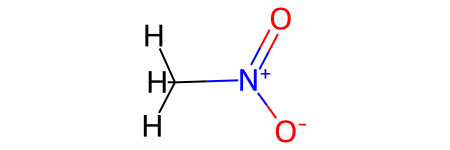

In [28]:
# SUCCESS
try:
    mol = Chem.MolFromMolBlock(
        pybel.readstring("xyz", xyz_block).write("sdf"), removeHs=False
    )
except Exception as e:
    print(e)
mol

### RDKit 😏

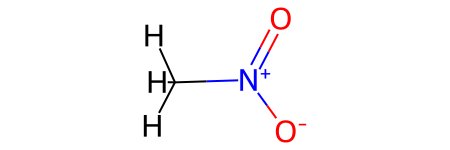

In [29]:
# SUCCESS
mol = Chem.MolFromXYZBlock(xyz_block)
try:
    rdDetermineBonds.DetermineBonds(mol, charge=0)
except Exception as e:
    print(e)
mol

### MolOP 😏

3 4 2 1


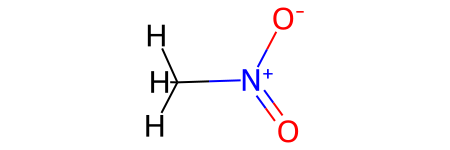

In [30]:
# SUCCESS
try:
    mol = xyz_block_to_rdmol(xyz_block, total_charge=0, total_radical=0)
except Exception as e:
    print(e)
mol

## Dipole (e.g. `C[N+]#[C-]`)

In [31]:
xyz_block = smi2xyz("C[N+]#[C-]")
print(xyz_block)

6

C     -0.442273    0.187993   -0.054760
N      0.842246   -0.393424    0.098413
C      1.885706   -0.844695    0.216347
H     -0.936553   -0.158805   -0.970139
H     -1.057222   -0.084126    0.799519
H     -0.291904    1.293057   -0.089380



### OpenBabel 😰

In [32]:
# FAILED
try:
    mol = Chem.MolFromMolBlock(
        pybel.readstring("xyz", xyz_block).write("sdf"), removeHs=False
    )
except Exception as e:
    print(e)
mol

### RDKit 😏

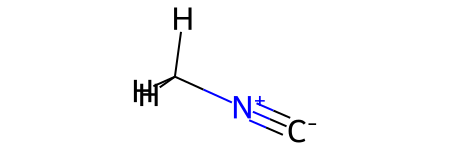

In [33]:
# SUCCESS
mol = Chem.MolFromXYZBlock(xyz_block)
try:
    rdDetermineBonds.DetermineBonds(mol, charge=0)
except Exception as e:
    print(e)
mol

### MolOP 😏

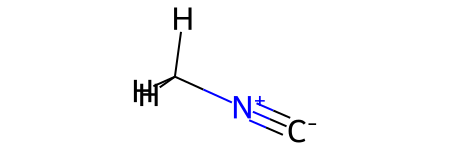

In [34]:
# SUCCESS
try:
    mol = xyz_block_to_rdmol(xyz_block, total_charge=0, total_radical=0)
except Exception as e:
    print(e)
mol

## Dipole (e.g. `C=[N+]=[N-]`)

In [35]:
xyz_block = smi2xyz("C=[N+]=[N-]")
print(xyz_block)

5

C     -0.507566    0.006027    0.001143
N      0.723277   -0.005179    0.233292
N      1.932968    0.008579   -0.077770
H     -1.064941    0.898872   -0.254763
H     -1.083738   -0.908298    0.048658



### OpenBabel 😰

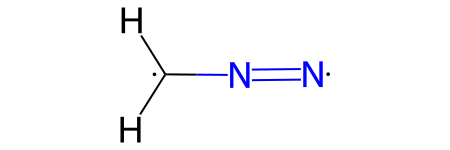

In [36]:
# FAILED
try:
    mol = Chem.MolFromMolBlock(
        pybel.readstring("xyz", xyz_block).write("sdf"), removeHs=False
    )
except Exception as e:
    print(e)
mol

### RDKit 😏

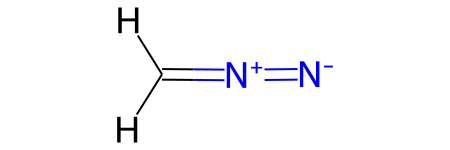

In [37]:
# SUCCESS
mol = Chem.MolFromXYZBlock(xyz_block)
try:
    rdDetermineBonds.DetermineBonds(mol, charge=0)
except Exception as e:
    print(e)
mol

### MolOP 😏

3 4 4 3


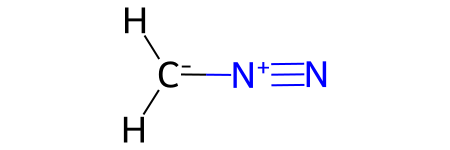

In [38]:
# SUCCESS
try:
    mol = xyz_block_to_rdmol(xyz_block, total_charge=0, total_radical=0)
except Exception as e:
    print(e)
mol

## Ylide (e.g. `c1ccccc1-P(-c1ccccc1)(-c1ccccc1)=C`)

## 

In [39]:
xyz_block = smi2xyz("c1ccccc1-P(-c1ccccc1)(-c1ccccc1)=C")
print(xyz_block)

37

C      1.782538   -1.193080    0.667514
C      2.824333   -2.069376    0.890306
C      3.394737   -2.786729   -0.153139
C      2.883853   -2.594407   -1.427055
C      1.834661   -1.710804   -1.646109
C      1.278366   -1.003717   -0.591792
P     -0.070869    0.137835   -0.847664
C      0.261526    1.697748   -0.022411
C      1.520667    2.009836    0.452138
C      1.775041    3.208095    1.085792
C      0.751932    4.134414    1.259156
C     -0.491869    3.791571    0.774018
C     -0.768672    2.599714    0.137579
C     -1.608409   -0.561945   -0.293731
C     -1.598136   -1.568119    0.640663
C     -2.753919   -2.156270    1.114697
C     -3.959360   -1.703795    0.619919
C     -3.969912   -0.682950   -0.328107
C     -2.786918   -0.113474   -0.783121
C     -0.212952    0.464558   -2.423040
H      1.385273   -0.667269    1.522733
H      3.233648   -2.231814    1.870013
H      4.215107   -3.476765    0.022357
H      3.326451   -3.149558   -2.229471
H      1.455256   -1.579894   -2.650

### OpenBabel 😰

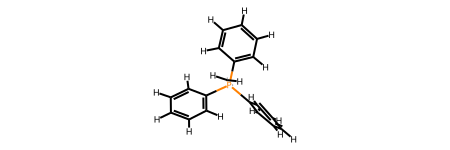

In [40]:
# FAILED
try:
    mol = Chem.MolFromMolBlock(
        pybel.readstring("xyz", xyz_block).write("sdf"), removeHs=False
    )
except Exception as e:
    print(e)
mol

### RDKit 😏

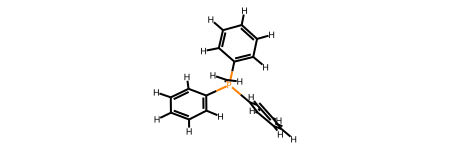

In [41]:
# SUCCESS
mol = Chem.MolFromXYZBlock(xyz_block)
try:
    rdDetermineBonds.DetermineBonds(mol, charge=0)
except Exception as e:
    print(e)
mol

### MolOP 😏

3 4 4 3


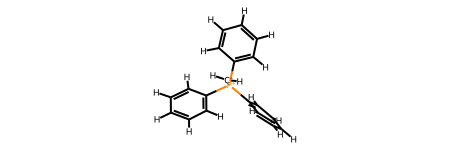

In [42]:
# SUCCESS
try:
    mol = xyz_block_to_rdmol(xyz_block, total_charge=0, total_radical=0)
except Exception as e:
    print(e)
mol

## Inner salt (e.g. `[O-]C(=O)CCCC[NH3+]`)

In [43]:
xyz_block = smi2xyz("[O-]C(=O)CCCC[NH3+]")
print(xyz_block)

19

O     -3.497035    1.535890   -0.107378
C     -3.024224    0.227652   -0.079676
O     -3.781376   -0.714849   -0.442898
C     -1.635492   -0.089096    0.371660
C     -0.764147   -0.318753   -0.817080
C      0.651737   -0.646184   -0.488508
C      1.297834    0.463160    0.289386
N      2.675637    0.173903    0.621940
H     -1.670267   -0.949095    1.067318
H     -1.305145    0.787412    0.965677
H     -0.806517    0.608780   -1.440613
H     -1.211557   -1.119465   -1.452855
H      1.234989   -0.777415   -1.434945
H      0.733234   -1.616566    0.040334
H      0.708724    0.627934    1.207785
H      1.258766    1.382312   -0.325614
H      2.927530   -0.823068    0.495446
H      3.319266    0.739412   -0.001199
H      2.888043    0.508036    1.601180



### OpenBabel 😰

In [44]:
# FAILED
try:
    mol = Chem.MolFromMolBlock(
        pybel.readstring("xyz", xyz_block).write("sdf"), removeHs=False
    )
except Exception as e:
    print(e)
mol

### RDKit 😏

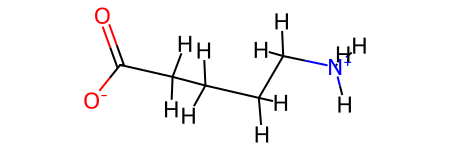

In [45]:
# SUCCESS
mol = Chem.MolFromXYZBlock(xyz_block)
try:
    rdDetermineBonds.DetermineBonds(mol, charge=0)
except Exception as e:
    print(e)
mol

### MolOP 😏

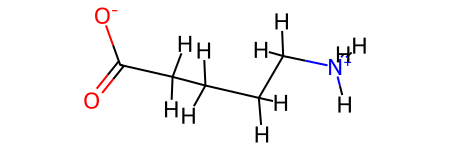

In [46]:
# SUCCESS
try:
    mol = xyz_block_to_rdmol(xyz_block, total_charge=0, total_radical=0)
except Exception as e:
    print(e)
mol

## Metal complex

In [47]:
xyz_block = AutoParser(
    "../../tests/test_files/g16log/S_Ph_Ni_TS.log",
)[
    0
][-1].to_XYZ_block()
print(xyz_block)

MolOP parsing with single thread: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]
INFO - 0 files failed to parse, 1 successfully parsed


47
charge 0 multiplicity 1
Ni           0.73613   0.07260  -0.04303
Br           2.32019   0.04379   1.90220
Br           2.64289   0.59055  -1.49799
N            0.44783   2.20870  -0.07042
C            0.08993   2.90740  -1.12890
C            0.80384   3.10411   0.91397
H           -0.20168   2.48670  -2.07975
C            0.64814   4.37871   0.43649
H            1.17333   2.75142   1.86475
H            0.01735   4.98363  -1.51917
H            0.82359   5.34692   0.87856
N           -0.73693   0.01678   1.25255
C           -1.78346   0.82464   1.20452
C           -0.83703  -0.72722   2.41518
H           -2.00544   1.52287   0.41919
C           -1.98111  -0.36500   3.06751
H           -0.06878  -1.43073   2.68716
H           -3.46472   1.05245   2.42732
H           -2.41182  -0.69264   3.99991
N           -2.55822   0.63058   2.29284
N            0.18716   4.23588  -0.86269
S           -0.28581  -0.48187  -2.05155
C           -1.94973  -1.27285  -2.03588
H           -2.17173  -1.33018

### OpenBabel 😰

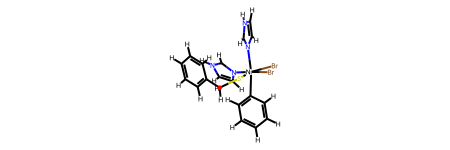

In [48]:
# FAILED
try:
    mol = Chem.MolFromMolBlock(
        pybel.readstring("xyz", xyz_block).write("sdf"), removeHs=False
    )
except Exception as e:
    print(e)
mol

### RDKit 😰

determineBondOrdering() does not work with element Ni


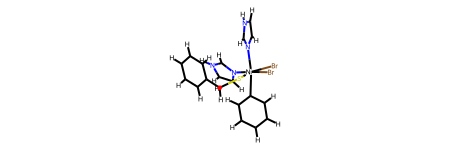

In [49]:
# FAILED
mol = Chem.MolFromXYZBlock(xyz_block)
try:
    rdDetermineBonds.DetermineBonds(mol, charge=0)
except Exception as e:
    print(e)
mol

### MolOP 😏

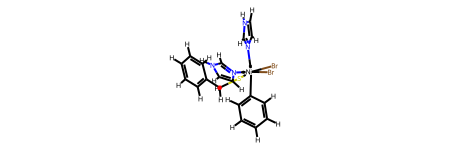

In [50]:
# SUCCESS
try:
    mol = xyz_block_to_rdmol(xyz_block, total_charge=0, total_radical=0)
except Exception as e:
    print(e)
mol